In [1]:
import numpy as np
import nibabel as nib
%matplotlib inline
import matplotlib.pyplot as plt
import albumentations as ab
from scipy.ndimage.filters import gaussian_filter, sobel
import skimage.transform as skTrans

In [38]:
def load_image(file_path):
    img = nib.load(file_path)
    return img.get_data()

def show_image(image, mask, index=0):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
    ax1.imshow(image[:, :, index], cmap='gray', vmin=0.0, vmax=1.0)
    #ax1.imshow(image[:, :, index])
    ax1.set_title('Original')
    ax2.imshow(mask[:, :, 7], cmap='gray', vmin=0.0, vmax=1.0)
    #ax2.imshow(mask[:, :, index])
    ax2.set_title('Augmented')

def do_crop_3d(image, x, y, z, h, w, d):

    return image[x:x + h, y:y + w, z:z + d, :]

def adjust_brightness(image, delta=0.125):

    return image + delta

def adjust_contrast(image, contrast_factor = 1.5):
    image_mean = np.mean(image)

    return (contrast_factor * (image - image_mean)) + image_mean

def rotate_image(image, rot):

    rotated_image = []

    if rot == 1:
        rotated_image = np.transpose(np.flip(image, 1), (1, 0, 2, 3))  # 90 deg Z
    elif rot == 2:
        rotated_image = np.flip(np.transpose(image, (1, 0, 2, 3)), 1)  # -90 deg Z
    elif rot == 3:
        rotated_image = np.flip(image, (0, 1))  # 180 degrees on z axis
    elif rot == 4:
        rotated_image = np.transpose(image, (0, 2, 1, 3))  # 90 deg X
    elif rot == 5:
        rotated_image = np.flip(np.transpose(image, (0, 2, 1, 3)), 1)  # -90 deg X
    elif rot == 6:
        rotated_image = np.flip(image, (1, 2))  # 180 degrees on x axis
    elif rot == 7:
        rotated_image = np.transpose(np.flip(image, 0), (2, 1, 0, 3))  # 90 deg Y
    elif rot == 8:
        rotated_image = np.transpose(np.flip(image, 0), (2, 1, 0, 3))  # -90 deg Y
    elif rot == 9:
        rotated_image = np.flip(image, (0, 2))  # 180 degrees on y axis

    return rotated_image


def resize(image, new_size):
    # image.shape[3] is the number of channels
    new_image = np.zeros((new_size, new_size, new_size, image.shape[3]))

    for z in range(image.shape[2]):
            new_image[:, :, z, :] = np.array(ab.Resize(new_size, new_size)(image=image[:,:,z])["image"])
    return new_image

def crop_and_resize(image, alpha=4):

    # All sides have the same size so anyone would do
    max_crop_length = int(image.shape[0] / alpha)
    max_start = (image.shape[0] - max_crop_length) - 2 # To make sure no IndexOutOfBound occurs

    # Select the starting point of the cropping randomly
    start_x = np.random.randint(0, max_start)
    start_y = np.random.randint(0, max_start)
    start_z = np.random.randint(0, max_start)

    # Cropp a cubic image, if another form of cropping is required then we need to pass different 
    # values instead of the same max_crop_length for all
    cropped_image = do_crop_3d(image, start_x, start_y, start_z, max_crop_length, max_crop_length, max_crop_length)
    
    return resize(cropped_image, image.shape[0])
    #return skTrans.resize(cropped_image, image.shape, order=1, preserve_range=True)

def add_gaussian_noise(image, max_mean=0.3, max_sigma=0.1):
    mean = np.random.uniform(-max_mean, max_mean)
    sigma = np.random.uniform(0.0, max_sigma)
    
    gauss = np.random.normal(mean, sigma,image.shape)
    
    return image + gauss

def apply_gaussian_filter(image, max_sigma=1.0):
    sigma = np.random.uniform(0.0, max_sigma)
    
    return gaussian_filter(image, sigma)

def apply_sobel_filter(image):
    dx = sobel(image, 0)
    dy = sobel(image, 1)
    dz = sobel(image, 2)
    
    mag = np.sqrt(dx**2 + dy**2 + dz**2)
    filtered  = mag * (1.0 / np.max(mag))
    
    return filtered

def cut_out(image, alpha=4):

    # All sides have the same size so anyone would do
    max_cutout_length = int(image.shape[0] / alpha)
    max_start = (image.shape[0] - max_cutout_length) - 2 # To make sure no IndexOutOfBound occurs

    # Select the starting point of the cropping randomly
    start_x = np.random.randint(0, max_start)
    end_x = start_x +  max_cutout_length
    
    start_y = np.random.randint(0, max_start)
    end_y = start_y + max_cutout_length
    
    start_z = np.random.randint(0, max_start)
    end_z = start_z +  max_cutout_length
    
    cutout_pixels = np.zeros((end_x - start_x, end_y - start_y, end_z - start_z,1))
    
    cutout_image = image.copy()
    cutout_image[start_x:end_x, start_y:end_y, start_z:end_z, :] =  cutout_pixels
    
    return cutout_image
    


(128, 128, 8, 1)


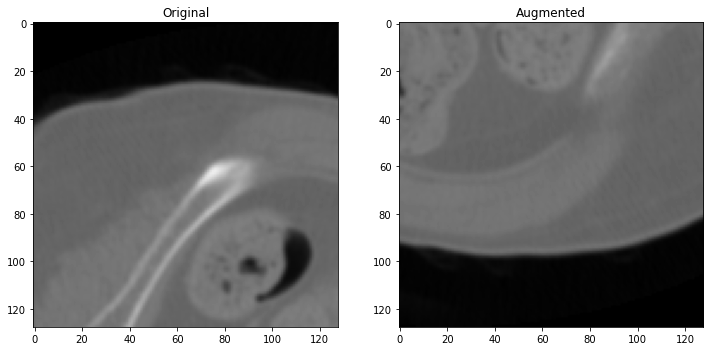

In [41]:
image = np.load("/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/result/train/pancreas_035_1.npy")
image = image[:,:,:8,:]
aug =   np.flip(image, (0,1))
print(aug.shape)
show_image(image, aug, 0)

In [15]:
#image = load_image("pancreas_001.nii.gz")
#image = load_image("my_image.nii")

image = np.load("/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/result/train/pancreas_035_1.npy")

#augmented = adjust_brightness(image)
#augmented = adjust_contrast(image)

image = image[:,:,:8, :]
print(image.shape)

for i in range(1,10):
    augmented = rotate_image(image,i)
    print(f'rot {i} - {augmented.shape}')
    #show_image(image, augmented)

#show_image(image, augmented, 0)
#augmented = crop_and_resize(image)
#augmented = add_gaussian_noise(image)
#augmented = apply_gaussian_filter(image)
#augmented = apply_sobel_filter(image)
#augmented = cut_out(image)

#show_image(image, augmented, 35)
#show_image(image, augmented, 0)
#show_image(image, augmented, 10)
#show_image(image, augmented, 10)

(128, 128, 8, 1)
rot 1 - (128, 128, 8, 1)
rot 2 - (128, 128, 8, 1)
rot 3 - (128, 128, 8, 1)
rot 4 - (128, 8, 128, 1)
rot 5 - (128, 8, 128, 1)
rot 6 - (128, 128, 8, 1)
rot 7 - (8, 128, 128, 1)
rot 8 - (8, 128, 128, 1)
rot 9 - (128, 128, 8, 1)


/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


(512, 480, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)
(128, 128, 128, 1)


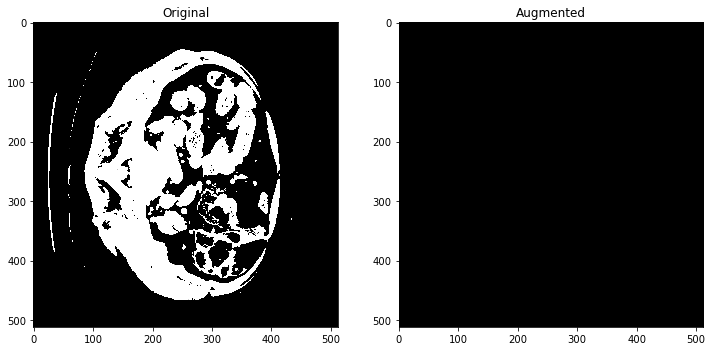

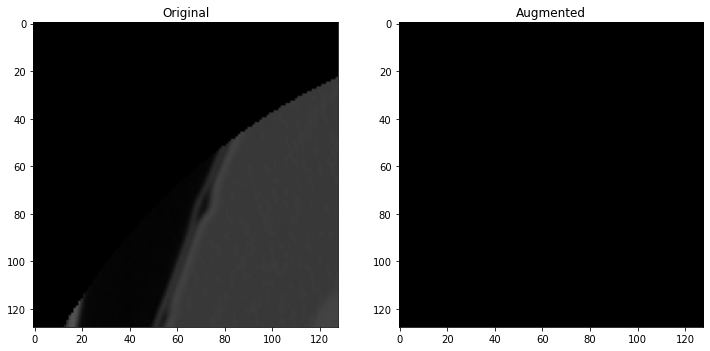

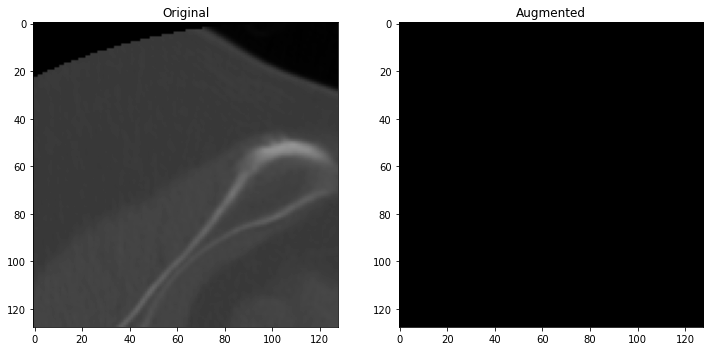

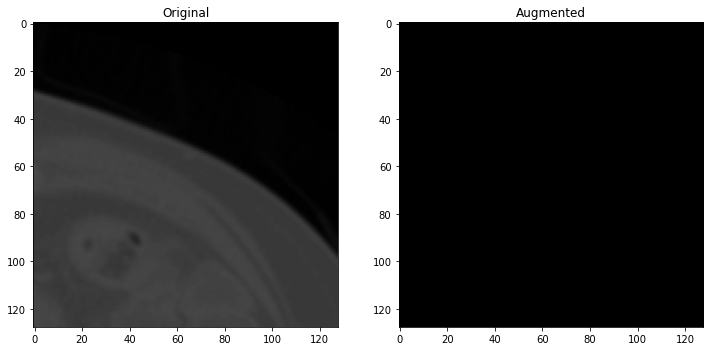

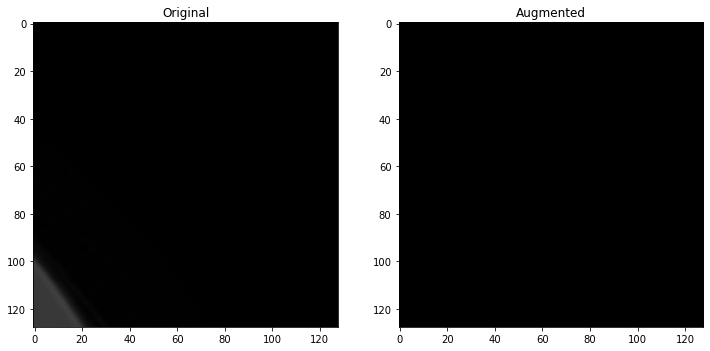

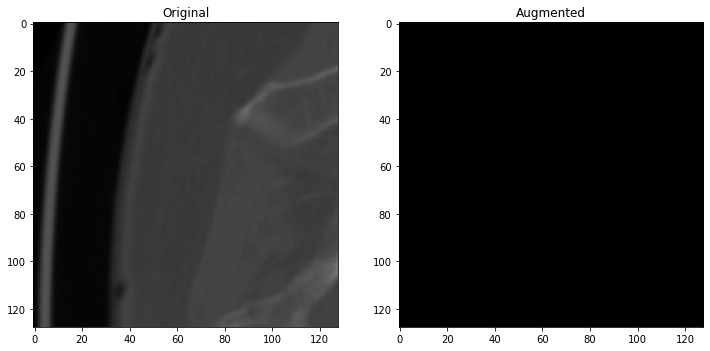

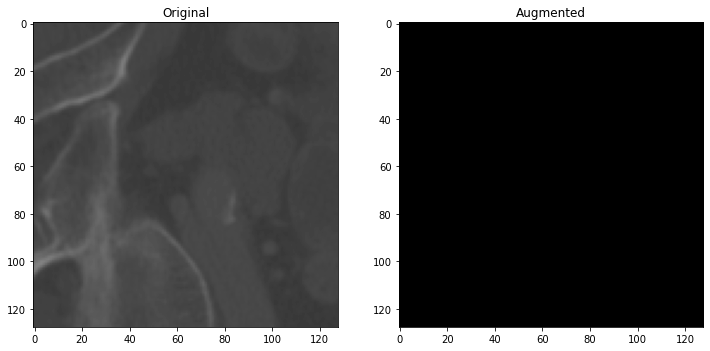

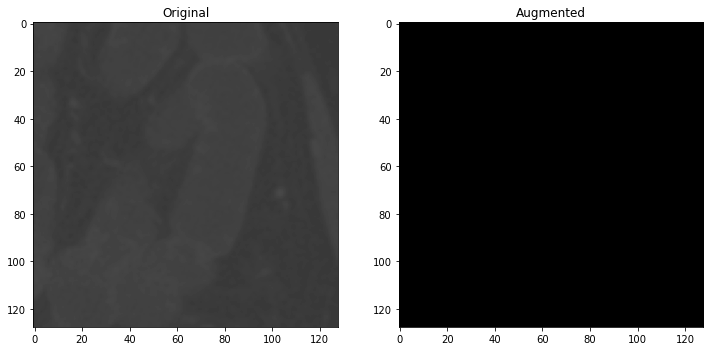

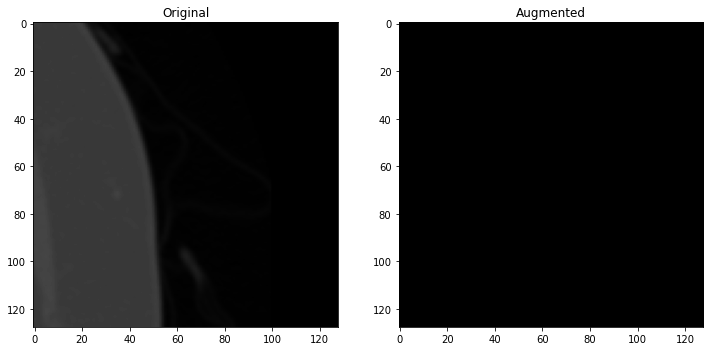

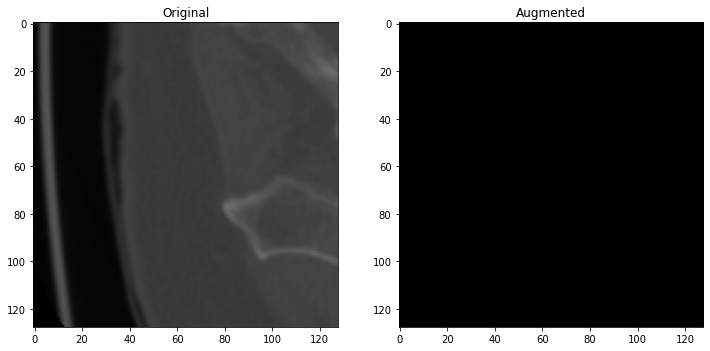

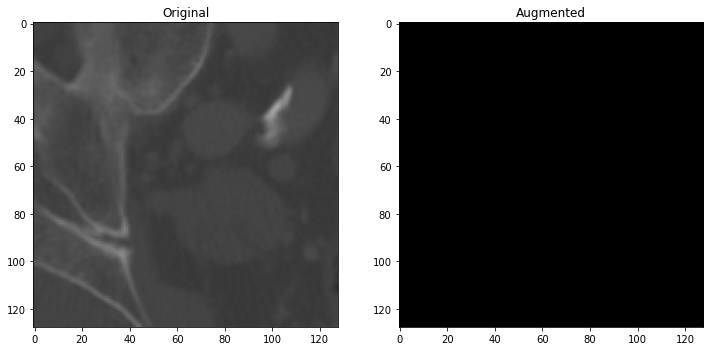

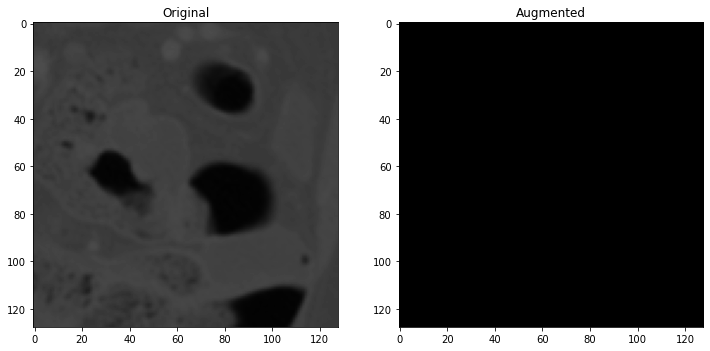

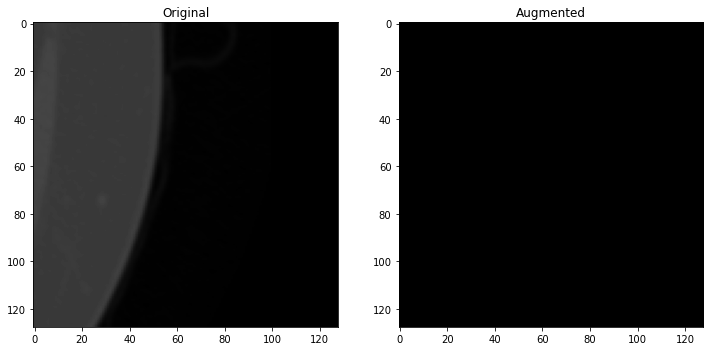

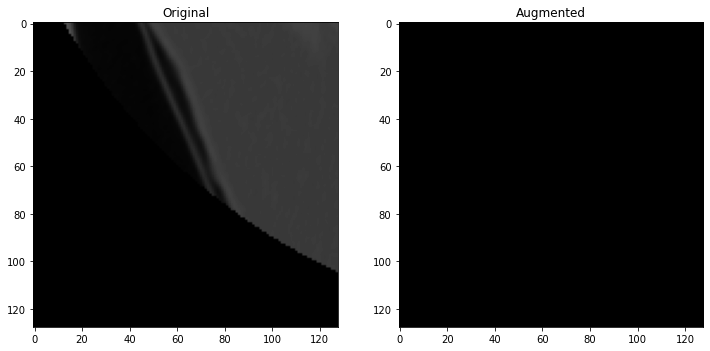

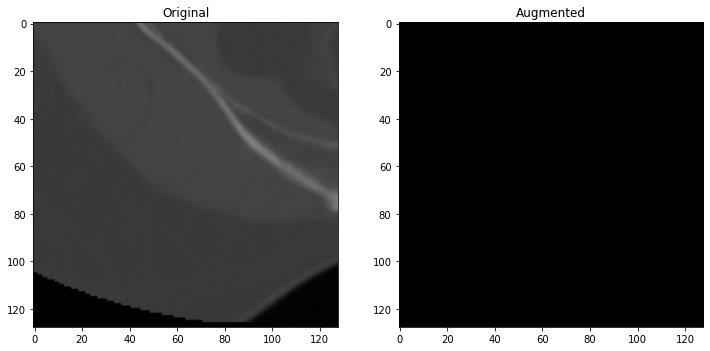

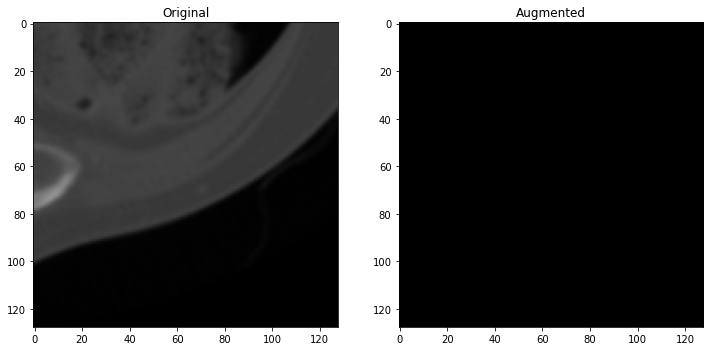

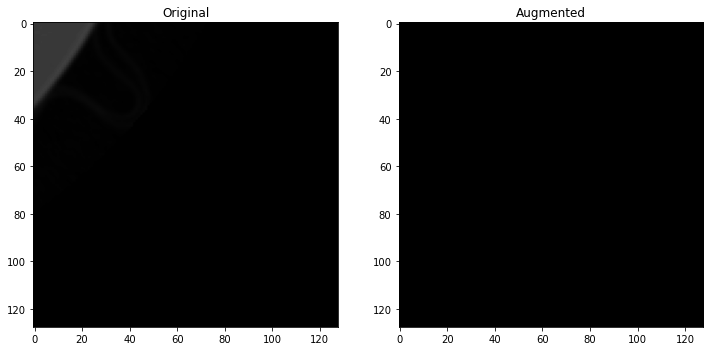

In [69]:
image_o = load_image("/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/pancreas_001.nii")
label_o = load_image("/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/pancreas_001_label.nii")
show_image(image_o, label_o, 0)
print(image.shape)

#image = np.load("/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/result/train/pancreas_046.npy")
#label = np.load("/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/result/train_labels/pancreas_046_label.npy")
#show_image(image, label, 40)


#for i in range(50,110):
 

for i in range(16):
    image_128 = np.load(f"/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/result/train/pancreas_001_{i}.npy")
    label_128 = np.load(f"/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/result/train_labels/pancreas_001_{i}_label.npy")
    print(image_128.shape)
    print(label_128.shape)
    
    show_image(image_128, label_128, 0)
    
#    image_64 = np.load(f"/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/result/train/pancreas_001_{i}.npy")
#    label_64 = np.load(f"/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/result/train_labels/pancreas_001_{i}_label.npy")
#    show_image(image_64, label_64, 25)
    







